# "Quantium Virtual Internship - Retail Strategy and Analytics - Task 2"

## Load required libraries and datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
data = pd.read_csv('QVI_data.csv')

In [3]:
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NCC,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smith,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smith,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


## Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present throughout the pre-trial period.

#### Calculate these measures over time for each store

#### Add a new month ID column in the data with the format yyyymm.

In [4]:
data['YEAR_MONTH'] = pd.to_datetime(data['DATE']).dt.strftime("%Y%m")

In [5]:
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEAR_MONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NCC,YOUNG SINGLES/COUPLES,Premium,201810
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget,201905
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smith,MIDAGE SINGLES/COUPLES,Budget,201905
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smith,MIDAGE SINGLES/COUPLES,Budget,201808
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget,201808


#### Next, we define the measure calculations to use during the analysis.
- For each store and month calculate total sales, number of customers,
transactions per customer, chips per customer and the average price per unit.

In [6]:
measureOverTime = data.groupby(['STORE_NBR', 'YEAR_MONTH']).apply(lambda group: pd.Series({
    'TOT_SALE': group['TOT_SALES'].sum(),
    'TOT_CUST': group['LYLTY_CARD_NBR'].nunique(),
    'PROD_QTY': group['PROD_QTY'].sum(),
    'TXN_PER_CUST': group['TXN_ID'].count() / group['LYLTY_CARD_NBR'].nunique(),
    'CHIPS_PER_TXN': group['PROD_QTY'].sum() / group['TXN_ID'].count(),
    'PRICE_PER_UNIT': group['TOT_SALES'].sum() / group['PROD_QTY'].sum()
})).reset_index()

measureOverTime

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT
0,1,201807,188.9,47.0,58.0,1.042553,1.183673,3.256897
1,1,201808,168.4,41.0,52.0,1.000000,1.268293,3.238462
2,1,201809,268.1,57.0,71.0,1.035088,1.203390,3.776056
3,1,201810,175.4,39.0,51.0,1.025641,1.275000,3.439216
4,1,201811,184.8,44.0,55.0,1.022727,1.222222,3.360000
...,...,...,...,...,...,...,...,...
3160,272,201902,385.3,44.0,89.0,1.068182,1.893617,4.329213
3161,272,201903,421.9,48.0,97.0,1.062500,1.901961,4.349485
3162,272,201904,445.1,54.0,105.0,1.037037,1.875000,4.239048
3163,272,201905,314.6,34.0,71.0,1.176471,1.775000,4.430986


#### Filter to the pre-trial period and stores with full observation periods

In [7]:
stores_with_full_obs = measureOverTime[measureOverTime.groupby('STORE_NBR')['STORE_NBR'].transform('size') == 12]['STORE_NBR'].unique()
#stores_with_full_obs 

In [8]:
# Filter pre-trial measures
preTrialMeasures = measureOverTime[(measureOverTime['YEAR_MONTH'] < '201902') & (measureOverTime['STORE_NBR'].isin(stores_with_full_obs))]
#preTrialMeasures

Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

#### Function to calculate correlation for a measure, looping through each control store.

In [9]:
def calculateCorrelation(df, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns=["Store1", "Store2", "corr_measure"])
    
    store_numbers = df["STORE_NBR"].unique()
    #store_numbers = store_numbers[store_numbers != store_comparison]
    
    trial_metric = df.loc[df["STORE_NBR"] == store_comparison, metric_col].values
    
    for store_number in store_numbers:
        control_metric = df.loc[df["STORE_NBR"] == store_number, metric_col].values
        
        correlation = stats.pearsonr(trial_metric, control_metric)[0]
        
        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison],
            "Store2": [store_number],
            "corr_measure": [correlation]
        })
        
        calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)
    
    return calc_corr_table

calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.

#### Function to calculate a standardised magnitude distance for a measure, looping through each control store

In [10]:
def calculateMagnitudeDistance(df, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=["Store1", "Store2", "YEAR_MONTH", "measure"])
    
    store_numbers = df["STORE_NBR"].unique()
    #store_numbers = store_numbers[store_numbers != store_comparison]
    
    trial_metric = df.loc[df["STORE_NBR"] == store_comparison, metric_col]

    for store_number in store_numbers:
        control_metric = df.loc[df["STORE_NBR"] == store_number, metric_col]
        
        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison] * len(df[df["STORE_NBR"] == store_number]),
            "Store2": [store_number] * len(df[df["STORE_NBR"] == store_number]),
            "YEAR_MONTH": df[df["STORE_NBR"] == store_number]["YEAR_MONTH"],
            "measure": abs(trial_metric.values - control_metric.values)
        })
        
        calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)
    
    # Standardize the magnitude distance so that the measure ranges from 0 to 1
    min_max_dist = calc_dist_table.groupby(["Store1", "YEAR_MONTH"])["measure"].agg(["min", "max"]).reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=["Store1", "YEAR_MONTH"])
    dist_table["magnitude_measure"] = 1 - (dist_table["measure"] - dist_table["min"]) / (dist_table["max"] - dist_table["min"])
    
    final_dist_table = dist_table.groupby(["Store1", "Store2"])["magnitude_measure"].mean().reset_index()
    final_dist_table.rename(columns={"magnitude_measure": "mag_measure"}, inplace=True)
    
    return final_dist_table


In [11]:
def plot_trial_control_stores(df, trial_store, control_store, metric_col, label, title_name):
    
    # Calculate mean total sales for control store
    control_avg = df[df["STORE_NBR"] == control_store].groupby("YEAR_MONTH")[metric_col].mean().reset_index()
    control_avg.rename(columns={metric_col: "CONTROL_AVG_SALE"}, inplace=True)

    # Merge with the main dataframe
    measureOverTimeData = pd.merge(df, control_avg, on="YEAR_MONTH", how="left")


    # Plot using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=measureOverTimeData[measureOverTimeData['MONTH'] < '2019-02-01'], x="MONTH", y=metric_col, hue="STORE_TYPE")
    ax.set(xlabel="Month of operation", ylabel=label, title=title_name)
    plt.xticks(rotation=45)
    plt.show()

#### Function calculate the scale factor

In [12]:
def scale_factor(df, trial_store, control_store, metric_col):
    # Calculate scaling factor for control sales
    scalingFactor = (df[(df["STORE_NBR"] == trial_store) & (df["YEAR_MONTH"] < '201902')][metric_col].sum() /
                      df[(df["STORE_NBR"] == control_store) & (df["YEAR_MONTH"] < '201902')][metric_col].sum())
    
    return scalingFactor


#### Function calculate the scaled control metrics

In [13]:
def scaled_matric(df, control_store, metric_col, scalingFactor):
    
    scaledControl = df[df["STORE_NBR"] == control_store].copy()
    scaledControl["CONTROL_SCALE"] = scaledControl[metric_col] * scalingFactor

    return scaledControl

#### Function calculate the percentage difference

In [14]:
def calculate_percentage_difference(df, scaledControl, trial_store, control_store, metric_col):
    
    percentageDiff = pd.merge(df[(df["STORE_NBR"] == trial_store)][['MONTH',metric_col]], scaledControl[['MONTH','CONTROL_SCALE']], on='MONTH')
    percentageDiff['PERCENT_DIFF'] = abs(percentageDiff[metric_col] - percentageDiff['CONTROL_SCALE']) / percentageDiff['CONTROL_SCALE']

    return percentageDiff

#### Function calculate the standard deviation in perecntage difference of the given parameter

In [15]:
def standard_deviation(percentageDiff):
    # Assuming you have the 'percentageDiff' column in the merged_data DataFrame
    stdDev = percentageDiff[percentageDiff["MONTH"] < '2019-02-01']["PERCENT_DIFF"].std()
    return stdDev

#### Function extract data for trial control store

In [16]:
def past(df, trial_store, control_store, metric_col):
    pastSales = df[(df["STORE_NBR"]==trial_store) | (df["STORE_NBR"]==control_store)][['MONTH', 'STORE_TYPE', metric_col]]\
          .reset_index(drop=True)

    return pastSales

#### Function calculate the 95 percentile confidence interval of trial control store

In [17]:
def past_control_95(df, stdDev, metric_col):
    pastSales_Controls95 = df[df['STORE_TYPE']=='Control'].copy()
    pastSales_Controls95['STORE_TYPE'] = 'Control 95th % confidence interval'
    pastSales_Controls95[metric_col] = pastSales_Controls95[metric_col] * (1 + (stdDev*2))
    
    return pastSales_Controls95 

#### Function calculate the 5 percentile confidence interval of trial control store

In [18]:
def past_control_5(df, stdDev, metric_col):
    pastSales_Controls5 = df[df['STORE_TYPE']=='Control'].copy()
    pastSales_Controls5['STORE_TYPE'] = 'Control 5th % confidence interval'
    pastSales_Controls5[metric_col] = pastSales_Controls5[metric_col] * (1 - (stdDev*2))
    
    return pastSales_Controls5 

#### Function plot the over all assesment of the stores

In [19]:
def plot_graph(df, metric_col, label, title_name):
    # Plotting these in one nice graph
    # Dataset for barplot
    bar_graph = df
    bar_graph["MONTH"] = pd.to_datetime(bar_graph["MONTH"]).dt.strftime("%Y-%m").astype("str")
    bar_graph = bar_graph.set_index("MONTH")
    bar_graph = bar_graph.iloc[:24,:]
    #bar_graph

    # Dataset for lineplot
    line_graph = df.set_index(["MONTH","STORE_TYPE"])[metric_col].unstack()
    line_graph = line_graph.iloc[:,[1,2]]
    #line_graph

    # Plotting
    fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
    ax2 = ax1.twinx()
    ax1 = sns.barplot(x=bar_graph.index, y=bar_graph[metric_col], hue=bar_graph["STORE_TYPE"], data=bar_graph,
                     palette=["peachpuff","lavender"])
    ax2 = sns.lineplot(data=line_graph, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
    # Yellow shadow to show values between 5% and 95% confidence 
    ax2.fill_between(line_graph.index, 
                     line_graph["Control 5th % confidence interval"], line_graph["Control 95th % confidence interval"], 
                     facecolor="yellow", alpha=0.5)
    # blue shadow to show trial period
    plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
    plt.title(title_name,fontsize=20)
    plt.xlabel("Month of Operation",fontsize=15)
    plt.ylabel(label, fontsize=15)
    plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

## STORE 77 

Now let's use the functions to find the control stores! We'll select control stores
based on how similar monthly total sales in dollar amounts and monthly number of
customers are to the trial stores. So we will need to use our functions to get four
scores, two for each of total sales and total customers.

In [20]:
trial_store = 77

In [21]:
# Calculate correlations
corr_nSales_77 = calculateCorrelation(preTrialMeasures, "TOT_SALE", trial_store)
corr_nCustomers_77 = calculateCorrelation(preTrialMeasures, "TOT_CUST", trial_store)

# Calculate magnitude distances
magnitude_nSales_77 = calculateMagnitudeDistance(preTrialMeasures, "TOT_SALE", trial_store)
magnitude_nCustomers_77 = calculateMagnitudeDistance(preTrialMeasures, "TOT_CUST", trial_store)

- Combine the all the scores calculated using our function to create a composite score to rank on.
- Take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.
- Create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table.

In [22]:
score_nSales_77 = pd.DataFrame({'Store1': corr_nSales_77['Store1'],
                             'Store2': corr_nSales_77['Store2'],
                             'ScoreNSale': 0.5 * corr_nSales_77['corr_measure'] + 0.5 * magnitude_nSales_77['mag_measure']})

score_nCustomers_77 = pd.DataFrame({'Store1': corr_nCustomers_77['Store1'],
                             'Store2': corr_nCustomers_77['Store2'],
                             'ScoreNCust': 0.5*corr_nCustomers_77['corr_measure'] + 0.5*magnitude_nCustomers_77['mag_measure']})

Combine scores across the drivers by first merging our sales scores and customer scores into a single table

In [23]:
score_Control_77 = pd.DataFrame({'Store1': score_nCustomers_77['Store1'],
                             'Store2': score_nCustomers_77['Store2'],
                             'finalControlScore': 0.5*score_nSales_77['ScoreNSale'] + 0.5*score_nCustomers_77['ScoreNCust']})\
                             .sort_values(by='finalControlScore', ascending=False)
score_Control_77

,Store1,Store2,finalControlScore
72,77,77,1.0
220,77,233,0.979046
46,77,50,0.878368
32,77,35,0.847766
240,77,254,0.834238
...,...,...,...
3,77,4,-0.067537
139,77,147,-0.0758
214,77,227,-0.079309
130,77,138,-0.079362


- The store with the highest score is then selected as the control store since it is most similar to the trial store.

- **Select control stores based on the highest matching store (closest to 1 but not the store itself, i.e. the second ranked highest store)**

- Select the most appropriate control store for **trial store** by finding the store with the highest final score.
as **control_store**

- **Store 77** is the store with the highest score that is selected as the control store.


In [24]:
control_store = 233

In [25]:
# Add Store_type column
measureOverTime_77 = measureOverTime

measureOverTime_77["STORE_TYPE"] = np.where(measureOverTime_77["STORE_NBR"] == trial_store, "Trial",
                                                  np.where(measureOverTime_77["STORE_NBR"] == control_store, "Control", "Other stores"))

# Convert YEARMONTH to DateTime
measureOverTime_77["MONTH"] = pd.to_datetime(measureOverTime_77["YEAR_MONTH"].astype(str).apply(lambda x: f"{x[:4]}-{x[4:]}-01"))

measureOverTime_77

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH
0,1,201807,188.9,47.0,58.0,1.042553,1.183673,3.256897,Other stores,2018-07-01
1,1,201808,168.4,41.0,52.0,1.000000,1.268293,3.238462,Other stores,2018-08-01
2,1,201809,268.1,57.0,71.0,1.035088,1.203390,3.776056,Other stores,2018-09-01
3,1,201810,175.4,39.0,51.0,1.025641,1.275000,3.439216,Other stores,2018-10-01
4,1,201811,184.8,44.0,55.0,1.022727,1.222222,3.360000,Other stores,2018-11-01
...,...,...,...,...,...,...,...,...,...,...
3160,272,201902,385.3,44.0,89.0,1.068182,1.893617,4.329213,Other stores,2019-02-01
3161,272,201903,421.9,48.0,97.0,1.062500,1.901961,4.349485,Other stores,2019-03-01
3162,272,201904,445.1,54.0,105.0,1.037037,1.875000,4.239048,Other stores,2019-04-01
3163,272,201905,314.6,34.0,71.0,1.176471,1.775000,4.430986,Other stores,2019-05-01


### SALES Analysis

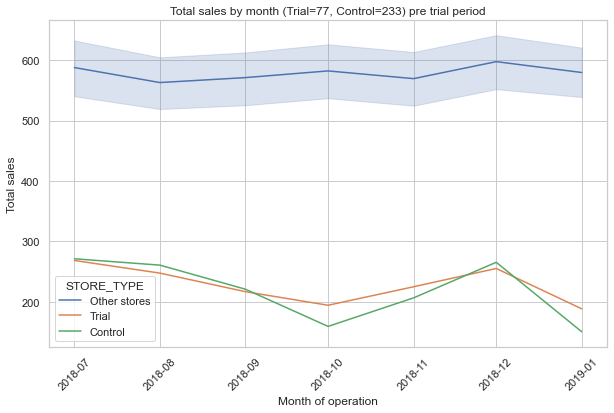

In [26]:
plot_trial_control_stores(measureOverTime_77, trial_store, control_store, "TOT_SALE", "Total sales", "Total sales by month (Trial=77, Control=233) pre trial period")

- The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.
- We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

#### Scale pre-trial control sales to match pre-trial trial store sales

In [27]:
scalingFactorForControlSales_77 = scale_factor(preTrialMeasures ,trial_store, control_store, "TOT_SALE")

#### Apply the scaling factor

In [28]:
scaledControlSales_77 = scaled_matric(measureOverTime_77, control_store, "TOT_SALE", scalingFactorForControlSales_77)
scaledControlSales_77

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH,CONTROL_SCALE
2695,233,201807,271.2,47.0,79.0,1.042553,1.612245,3.432911,Control,2018-07-01,281.980841
2696,233,201808,260.7,44.0,72.0,1.022727,1.600000,3.620833,Control,2018-08-01,271.063441
2697,233,201809,220.9,40.0,68.0,1.075000,1.581395,3.248529,Control,2018-09-01,229.681297
2698,233,201810,159.3,32.0,48.0,1.000000,1.500000,3.318750,Control,2018-10-01,165.632551
2699,233,201811,206.5,39.0,61.0,1.025641,1.525000,3.385246,Control,2018-11-01,214.708863
2700,233,201812,265.4,43.0,70.0,1.046512,1.555556,3.791429,Control,2018-12-01,275.950277
2701,233,201901,150.5,31.0,41.0,1.000000,1.322581,3.670732,Control,2019-01-01,156.482731
2702,233,201902,220.7,42.0,64.0,1.023810,1.488372,3.448438,Control,2019-02-01,229.473346
2703,233,201903,180.6,35.0,52.0,1.028571,1.444444,3.473077,Control,2019-03-01,187.779277
2704,233,201904,144.2,27.0,41.0,1.074074,1.413793,3.517073,Control,2019-04-01,149.932291


Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales.

#### Calculate the percentage difference between scaled control sales and trial sales

In [29]:
percentageDiffSales_77 = calculate_percentage_difference(measureOverTime_77, scaledControlSales_77, trial_store, control_store, "TOT_SALE")
percentageDiffSales_77

,MONTH,TOT_SALE,CONTROL_SCALE,PERCENT_DIFF
0,2018-07-01,268.4,281.980841,0.048162
1,2018-08-01,247.5,271.063441,0.086930
2,2018-09-01,216.8,229.681297,0.056083
3,2018-10-01,194.3,165.632551,0.173079
4,2018-11-01,224.9,214.708863,0.047465
5,2018-12-01,255.2,275.950277,0.075196
6,2019-01-01,188.4,156.482731,0.203967
7,2019-02-01,211.6,229.473346,0.077889
8,2019-03-01,255.1,187.779277,0.358510
9,2019-04-01,258.1,149.932291,0.721444


#### Hypothesis Analysis
- **H0** = The trial period is the same as the pre-trial period
- **HA** = The trial period is not the same as the pre-trial period

#### As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period

In [30]:
# Assuming you have the 'percentageDiff' column in the merged_data DataFrame
stdDevSales_77 = standard_deviation(percentageDiffSales_77)
stdDevSales_77


0.06363898833418727

#### We will test with a null hypothesis of there being 0 difference between trial and control stores.
- Calculate the t-values for the trial months.
- After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

#### The test statistic here is (x - u)/standard deviation

In [31]:
percentageDiffSales_77['tValue'] = (percentageDiffSales_77['PERCENT_DIFF'] - 0) / stdDevSales_77
percentageDiffSales_77[(percentageDiffSales_77['MONTH'] >= '2019-02-01') & (percentageDiffSales_77['MONTH'] < '2019-05-01')]

,MONTH,TOT_SALE,CONTROL_SCALE,PERCENT_DIFF,tValue
7,2019-02-01,211.6,229.473346,0.077889,1.223912
8,2019-03-01,255.1,187.779277,0.358510,5.633494
9,2019-04-01,258.1,149.932291,0.721444,11.336505


The 95th percentile of the t distribution with the appropriate degrees of freedom
- There are 8 months in the pre-trial period, hence degrees of freedom = 8 - 1 = 7

In [32]:
percentile_95 = stats.t.ppf(0.95, df=7)
percentile_95

1.8945786050613047

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

#### Trial and control store total sales
#### Create new variables Store_type, totSales and TransactionMonth in the data table.

In [33]:
pastSales_77 = past(measureOverTime_77, trial_store, control_store, "TOT_SALE")
#pastSales_77

#### Control store 95th percentile

In [34]:
pastSales_Controls95_77 = past_control_95(pastSales_77, stdDevSales_77, "TOT_SALE")

#### Control store 5th percentile

In [35]:
pastSales_Controls5_77 = past_control_5(pastSales_77, stdDevSales_77, "TOT_SALE")

In [36]:
trialAssessmentSales_77 = pd.concat([pastSales_77, pastSales_Controls95_77, pastSales_Controls5_77], ignore_index=True)
trialAssessmentSales_77


,MONTH,STORE_TYPE,TOT_SALE
0,2018-07-01,Trial,268.400000
1,2018-08-01,Trial,247.500000
2,2018-09-01,Trial,216.800000
3,2018-10-01,Trial,194.300000
4,2018-11-01,Trial,224.900000
5,2018-12-01,Trial,255.200000
6,2019-01-01,Trial,188.400000
7,2019-02-01,Trial,211.600000
8,2019-03-01,Trial,255.100000
9,2019-04-01,Trial,258.100000


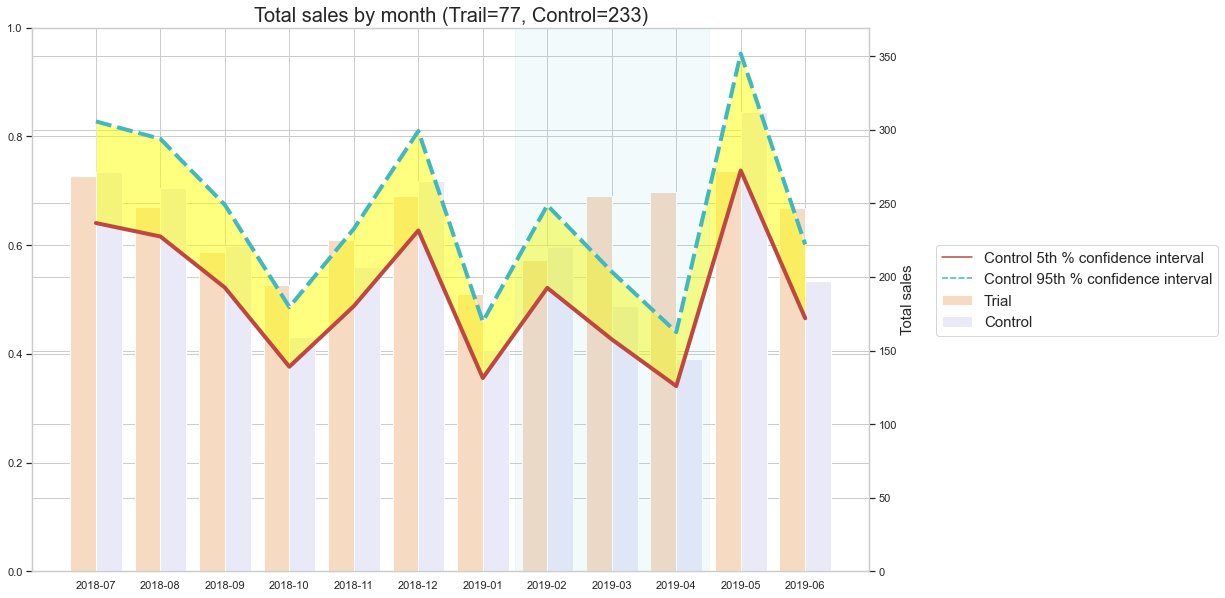

In [37]:
plot_graph(trialAssessmentSales_77, "TOT_SALE", "Total sales", "Total sales by month (Trail=77, Control=233)")

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

### Customer Analysis

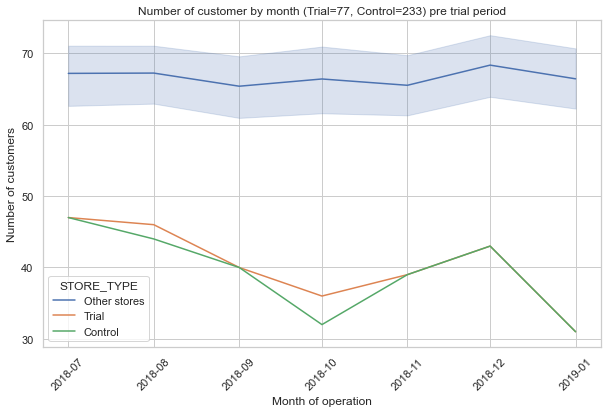

In [38]:
plot_trial_control_stores(measureOverTime_77, trial_store, control_store, "TOT_CUST", "Number of customers", "Number of customer by month (Trial=77, Control=233) pre trial period")

##### Scale pre-trial control customers to match pre-trial trial store sales

In [39]:
scalingFactorForControlCustomers_77 = scale_factor(preTrialMeasures ,trial_store, control_store, "TOT_CUST")

##### Apply the scaling factor

In [40]:
scaledControlCustomers_77 = scaled_matric(measureOverTime_77, control_store, "TOT_CUST", scalingFactorForControlCustomers_77)
scaledControlCustomers_77

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH,CONTROL_SCALE
2695,233,201807,271.2,47.0,79.0,1.042553,1.612245,3.432911,Control,2018-07-01,48.021739
2696,233,201808,260.7,44.0,72.0,1.022727,1.600000,3.620833,Control,2018-08-01,44.956522
2697,233,201809,220.9,40.0,68.0,1.075000,1.581395,3.248529,Control,2018-09-01,40.869565
2698,233,201810,159.3,32.0,48.0,1.000000,1.500000,3.318750,Control,2018-10-01,32.695652
2699,233,201811,206.5,39.0,61.0,1.025641,1.525000,3.385246,Control,2018-11-01,39.847826
2700,233,201812,265.4,43.0,70.0,1.046512,1.555556,3.791429,Control,2018-12-01,43.934783
2701,233,201901,150.5,31.0,41.0,1.000000,1.322581,3.670732,Control,2019-01-01,31.673913
2702,233,201902,220.7,42.0,64.0,1.023810,1.488372,3.448438,Control,2019-02-01,42.913043
2703,233,201903,180.6,35.0,52.0,1.028571,1.444444,3.473077,Control,2019-03-01,35.760870
2704,233,201904,144.2,27.0,41.0,1.074074,1.413793,3.517073,Control,2019-04-01,27.586957


#### Calculate the percentage difference between scaled control sales and trial sales

In [41]:
percentageDiffCustomers_77 = calculate_percentage_difference(measureOverTime_77, scaledControlCustomers_77, trial_store, control_store, "TOT_CUST")
percentageDiffCustomers_77

,MONTH,TOT_CUST,CONTROL_SCALE,PERCENT_DIFF
0,2018-07-01,47.0,48.021739,0.021277
1,2018-08-01,46.0,44.956522,0.023211
2,2018-09-01,40.0,40.869565,0.021277
3,2018-10-01,36.0,32.695652,0.101064
4,2018-11-01,39.0,39.847826,0.021277
5,2018-12-01,43.0,43.934783,0.021277
6,2019-01-01,31.0,31.673913,0.021277
7,2019-02-01,40.0,42.913043,0.067882
8,2019-03-01,46.0,35.760870,0.286322
9,2019-04-01,47.0,27.586957,0.703704


### Hypothesis Analysis
- **H0** = The trial period is the same as the pre-trial period
- **HA** = The trial period is not the same as the pre-trial period
- As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period


In [42]:
# Assuming you have the 'percentageDiff' column in the merged_data DataFrame
stdDevCustomers_77 = standard_deviation(percentageDiffCustomers_77)
stdDevCustomers_77

0.030043543491747902

#### We will test with a null hypothesis of there being 0 difference between trial and control stores.
- Calculate the t-values for the trial months.
- After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

#### The test statistic here is (x - u)/standard deviation

In [43]:
percentageDiffCustomers_77['tValue'] = (percentageDiffCustomers_77['PERCENT_DIFF'] - 0) / stdDevCustomers_77
percentageDiffCustomers_77[(percentageDiffCustomers_77['MONTH'] >= '2019-02-01') & (percentageDiffCustomers_77['MONTH'] < '2019-05-01')]

,MONTH,TOT_CUST,CONTROL_SCALE,PERCENT_DIFF,tValue
7,2019-02-01,40.0,42.913043,0.067882,2.259470
8,2019-03-01,46.0,35.760870,0.286322,9.530240
9,2019-04-01,47.0,27.586957,0.703704,23.422793


- The 95th percentile of the t distribution with the appropriate degrees of freedom
- There are 8 months in the pre-trial period, hence degrees of freedom = 8 - 1 = 7

In [44]:
percentile_95 = stats.t.ppf(0.95, df=7)
percentile_95

1.8945786050613047

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.
#### Trial and control store total sales

In [45]:
pastCustomers_77 = past(measureOverTime_77, trial_store, control_store, "TOT_CUST")
#pastSales_77

#### Control store 95th percentile

In [46]:
pastCustomers_Controls95_77 = past_control_95(pastCustomers_77, stdDevCustomers_77, "TOT_CUST")

#### Control store 5th percentile

In [47]:
pastCustomers_Controls5_77 = past_control_5(pastCustomers_77, stdDevCustomers_77, "TOT_CUST")

In [48]:
trialAssessmentCustomers_77 = pd.concat([pastCustomers_77, pastCustomers_Controls95_77, pastCustomers_Controls5_77], ignore_index=True)
trialAssessmentCustomers_77

,MONTH,STORE_TYPE,TOT_CUST
0,2018-07-01,Trial,47.000000
1,2018-08-01,Trial,46.000000
2,2018-09-01,Trial,40.000000
3,2018-10-01,Trial,36.000000
4,2018-11-01,Trial,39.000000
5,2018-12-01,Trial,43.000000
6,2019-01-01,Trial,31.000000
7,2019-02-01,Trial,40.000000
8,2019-03-01,Trial,46.000000
9,2019-04-01,Trial,47.000000


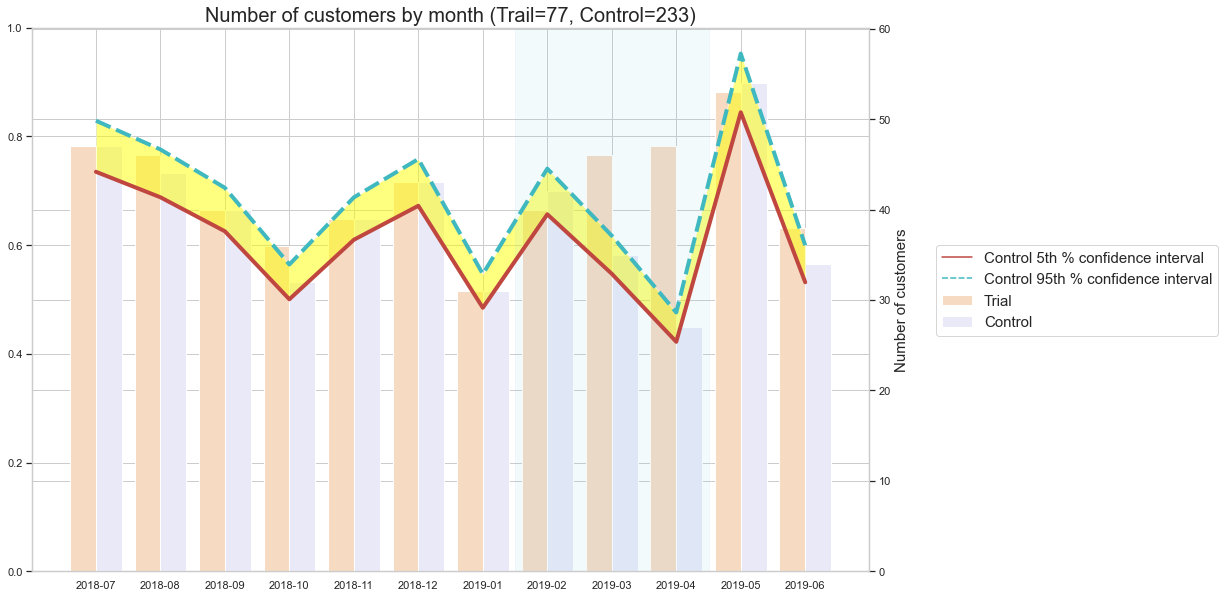

In [49]:
plot_graph(trialAssessmentCustomers_77, "TOT_CUST", "Number of customers", "Number of customers by month (Trail=77, Control=233)")

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

## STORE 86

Now let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [50]:
trial_store = 86

In [51]:
# Calculate correlations
corr_nSales_86 = calculateCorrelation(preTrialMeasures, "TOT_SALE", trial_store)
corr_nCustomers_86 = calculateCorrelation(preTrialMeasures, "TOT_CUST", trial_store)

# Calculate magnitude distances
magnitude_nSales_86 = calculateMagnitudeDistance(preTrialMeasures, "TOT_SALE", trial_store)
magnitude_nCustomers_86 = calculateMagnitudeDistance(preTrialMeasures, "TOT_CUST", trial_store)

- Combine the all the scores calculated using our function to create a composite score to rank on.
- Take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.
- Create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table.

In [52]:
score_nSales_86 = pd.DataFrame({'Store1': corr_nSales_86['Store1'],
                             'Store2': corr_nSales_86['Store2'],
                             'ScoreNSale': 0.5 * corr_nSales_86['corr_measure'] + 0.5 * magnitude_nSales_86['mag_measure']})

In [53]:
score_nCustomers_86 = pd.DataFrame({'Store1': corr_nCustomers_86['Store1'],
                             'Store2': corr_nCustomers_86['Store2'],
                             'ScoreNCust': 0.5*corr_nCustomers_86['corr_measure'] + 0.5*magnitude_nCustomers_86['mag_measure']})


Combine scores across the drivers by first merging our sales scores and customer scores into a single table

In [54]:
score_Control_86 = pd.DataFrame({'Store1': score_nCustomers_86['Store1'],
                             'Store2': score_nCustomers_86['Store2'],
                             'finalControlScore': 0.5*score_nSales_86['ScoreNSale'] + 0.5*score_nCustomers_86['ScoreNCust']})\
                             .sort_values(by='finalControlScore', ascending=False)
score_Control_86

,Store1,Store2,finalControlScore
80,86,86,1.0
147,86,155,0.908037
107,86,114,0.874358
130,86,138,0.82385
52,86,56,0.760301
...,...,...,...
48,86,52,-0.206554
183,86,192,-0.224959
112,86,120,-0.234063
39,86,42,-0.289528


- The store with the highest score is then selected as the control store since it is most similar to the trial store.
- Select control stores based on the highest matching store (closest to 1 but not the store itself, i.e. the second ranked highest store)
- Select the most appropriate control store for trial store by finding the store with the highest final score. as control_store
- Store 86 is the store with the highest score that is selected as the control store.

In [55]:
control_store = 155

In [56]:
# Add Store_type column
measureOverTime_86 = measureOverTime

measureOverTime_86["STORE_TYPE"] = np.where(measureOverTime_86["STORE_NBR"] == trial_store, "Trial",
                                                  np.where(measureOverTime_86["STORE_NBR"] == control_store, "Control", "Other stores"))

# Convert YEARMONTH to DateTime
measureOverTime_86["MONTH"] = pd.to_datetime(measureOverTime_86["YEAR_MONTH"].astype(str).apply(lambda x: f"{x[:4]}-{x[4:]}-01"))

measureOverTime_86

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH
0,1,201807,188.9,47.0,58.0,1.042553,1.183673,3.256897,Other stores,2018-07-01
1,1,201808,168.4,41.0,52.0,1.000000,1.268293,3.238462,Other stores,2018-08-01
2,1,201809,268.1,57.0,71.0,1.035088,1.203390,3.776056,Other stores,2018-09-01
3,1,201810,175.4,39.0,51.0,1.025641,1.275000,3.439216,Other stores,2018-10-01
4,1,201811,184.8,44.0,55.0,1.022727,1.222222,3.360000,Other stores,2018-11-01
...,...,...,...,...,...,...,...,...,...,...
3160,272,201902,385.3,44.0,89.0,1.068182,1.893617,4.329213,Other stores,2019-02-01
3161,272,201903,421.9,48.0,97.0,1.062500,1.901961,4.349485,Other stores,2019-03-01
3162,272,201904,445.1,54.0,105.0,1.037037,1.875000,4.239048,Other stores,2019-04-01
3163,272,201905,314.6,34.0,71.0,1.176471,1.775000,4.430986,Other stores,2019-05-01


### SALES Analysis

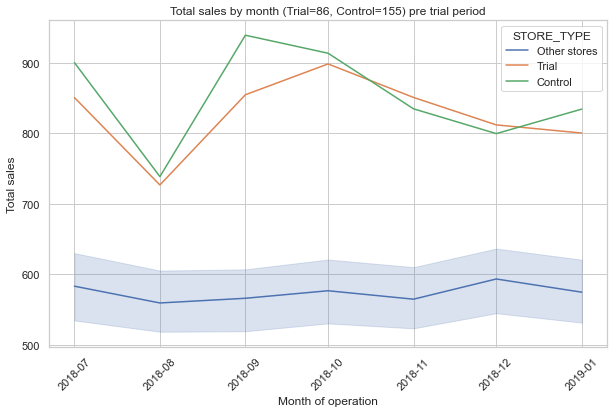

In [57]:
plot_trial_control_stores(measureOverTime_86, trial_store, control_store, "TOT_SALE", "Total sales", "Total sales by month (Trial=86, Control=155) pre trial period")

- The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.
- We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

##### Scale pre-trial control sales to match pre-trial trial store sales

In [58]:
scalingFactorForControlSales_86 = scale_factor(preTrialMeasures ,trial_store, control_store, "TOT_SALE")

##### Apply the scaling factor

In [59]:
scaledControlSales_86 = scaled_matric(measureOverTime_86, control_store, "TOT_SALE", scalingFactorForControlSales_86)
scaledControlSales_86

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH,CONTROL_SCALE
1792,155,201807,900.60,98.0,240.0,1.224490,2.000000,3.752500,Control,2018-07-01,875.427669
1793,155,201808,738.70,88.0,216.0,1.295455,1.894737,3.419907,Control,2018-08-01,718.052875
1794,155,201809,939.60,96.0,262.0,1.364583,2.000000,3.586260,Control,2018-09-01,913.337595
1795,155,201810,914.00,105.0,256.0,1.219048,2.000000,3.570312,Control,2018-10-01,888.453131
1796,155,201811,835.00,96.0,248.0,1.291667,2.000000,3.366935,Control,2018-11-01,811.661230
1797,155,201812,799.80,91.0,226.0,1.241758,2.000000,3.538938,Control,2018-12-01,777.445092
1798,155,201901,834.60,92.0,236.0,1.282609,2.000000,3.536441,Control,2019-01-01,811.272410
1799,155,201902,850.80,92.0,238.0,1.293478,2.000000,3.574790,Control,2019-02-01,827.019610
1800,155,201903,767.00,91.0,224.0,1.230769,2.000000,3.424107,Control,2019-03-01,745.561872
1801,155,201904,800.40,93.0,228.0,1.225806,2.000000,3.510526,Control,2019-04-01,778.028321


#### Calculate the percentage difference between scaled control sales and trial sales

In [60]:
percentageDiffSales_86 = calculate_percentage_difference(measureOverTime_86, scaledControlSales_86, trial_store, control_store, "TOT_SALE")
percentageDiffSales_86

,MONTH,TOT_SALE,CONTROL_SCALE,PERCENT_DIFF
0,2018-07-01,851.00,875.427669,0.027904
1,2018-08-01,726.85,718.052875,0.012251
2,2018-09-01,855.00,913.337595,0.063873
3,2018-10-01,898.80,888.453131,0.011646
4,2018-11-01,851.20,811.661230,0.048713
5,2018-12-01,812.20,777.445092,0.044704
6,2019-01-01,800.60,811.272410,0.013155
7,2019-02-01,872.80,827.019610,0.055356
8,2019-03-01,945.40,745.561872,0.268037
9,2019-04-01,804.00,778.028321,0.033381


### Hypothesis Analysis
- **H0** = The trial period is the same as the pre-trial period
- **HA** = The trial period is not the same as the pre-trial period
- As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period


In [61]:
stdDevSales_86 = standard_deviation(percentageDiffSales_86)
stdDevSales_86

0.020945888446244097

#### We will test with a null hypothesis of there being 0 difference between trial and control stores.
- Calculate the t-values for the trial months.
- After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.
#### The test statistic here is (x - u)/standard deviation

In [62]:
percentageDiffSales_86['tValue'] = (percentageDiffSales_86['PERCENT_DIFF'] - 0) / stdDevSales_86
percentageDiffSales_86[(percentageDiffSales_86['MONTH'] >= '2019-02-01') & (percentageDiffSales_86['MONTH'] < '2019-05-01')]

,MONTH,TOT_SALE,CONTROL_SCALE,PERCENT_DIFF,tValue
7,2019-02-01,872.8,827.019610,0.055356,2.642804
8,2019-03-01,945.4,745.561872,0.268037,12.796638
9,2019-04-01,804.0,778.028321,0.033381,1.593697


- The 95th percentile of the t distribution with the appropriate degrees of freedom
- There are 8 months in the pre-trial period, hence degrees of freedom = 8 - 1 = 7

In [63]:
percentile_95 = stats.t.ppf(0.95, df=7)
percentile_95

1.8945786050613047

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.
#### Trial and control store total sales

In [64]:
pastSales_86 = past(measureOverTime_77, trial_store, control_store, "TOT_SALE")
#pastSales_86

#### Control store 95th percentile

In [65]:
pastSales_Controls95_86 = past_control_95(pastSales_86, stdDevSales_86, "TOT_SALE")

#### Control store 5th percentile

In [66]:
pastSales_Controls5_86 = past_control_5(pastSales_86, stdDevSales_86, "TOT_SALE")

In [67]:
# Assuming you have the pastSales, pastSales_Controls95, and pastSales_Controls5 DataFrames
trialAssessment_86 = pd.concat([pastSales_86, pastSales_Controls95_86, pastSales_Controls5_86], ignore_index=True)
trialAssessment_86

,MONTH,STORE_TYPE,TOT_SALE
0,2018-07-01,Trial,851.000000
1,2018-08-01,Trial,726.850000
2,2018-09-01,Trial,855.000000
3,2018-10-01,Trial,898.800000
4,2018-11-01,Trial,851.200000
5,2018-12-01,Trial,812.200000
6,2019-01-01,Trial,800.600000
7,2019-02-01,Trial,872.800000
8,2019-03-01,Trial,945.400000
9,2019-04-01,Trial,804.000000


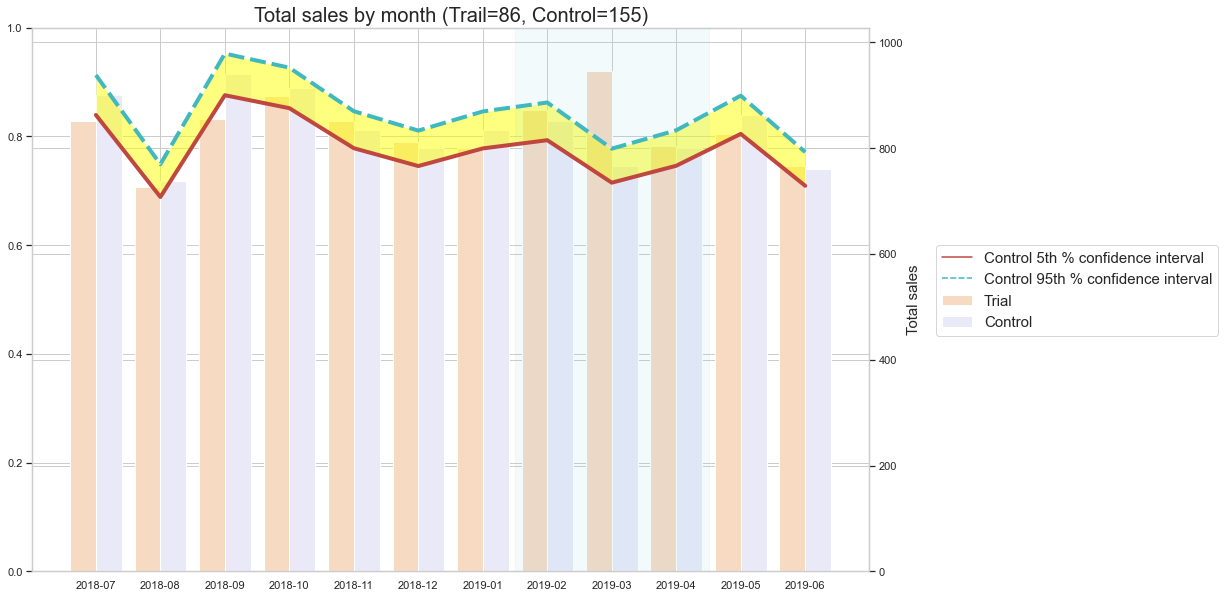

In [68]:
plot_graph(trialAssessment_86, "TOT_SALE", "Total sales", "Total sales by month (Trail=86, Control=155)")

The results show that the trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies **inside** the 5% to 95% confidence interval of the control store in two of the three trial months.

### Customer Analysis

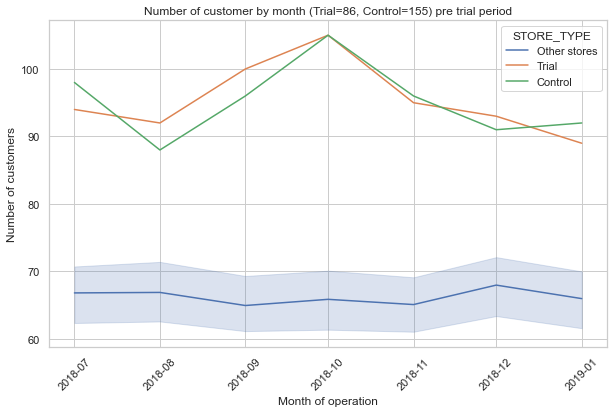

In [69]:
plot_trial_control_stores(measureOverTime_86, trial_store, control_store, "TOT_CUST", "Number of customers", "Number of customer by month (Trial=86, Control=155) pre trial period")

##### Scale pre-trial control sales to match pre-trial trial store sales

In [70]:
scalingFactorForControlCustomers_86 = scale_factor(preTrialMeasures ,trial_store, control_store, "TOT_CUST")

##### Apply the scaling factor

In [71]:
scaledControlCustomers_86 = scaled_matric(measureOverTime_86, control_store, "TOT_CUST", scalingFactorForControlCustomers_86)
scaledControlCustomers_86

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH,CONTROL_SCALE
1792,155,201807,900.60,98.0,240.0,1.224490,2.000000,3.752500,Control,2018-07-01,98.294294
1793,155,201808,738.70,88.0,216.0,1.295455,1.894737,3.419907,Control,2018-08-01,88.264264
1794,155,201809,939.60,96.0,262.0,1.364583,2.000000,3.586260,Control,2018-09-01,96.288288
1795,155,201810,914.00,105.0,256.0,1.219048,2.000000,3.570312,Control,2018-10-01,105.315315
1796,155,201811,835.00,96.0,248.0,1.291667,2.000000,3.366935,Control,2018-11-01,96.288288
1797,155,201812,799.80,91.0,226.0,1.241758,2.000000,3.538938,Control,2018-12-01,91.273273
1798,155,201901,834.60,92.0,236.0,1.282609,2.000000,3.536441,Control,2019-01-01,92.276276
1799,155,201902,850.80,92.0,238.0,1.293478,2.000000,3.574790,Control,2019-02-01,92.276276
1800,155,201903,767.00,91.0,224.0,1.230769,2.000000,3.424107,Control,2019-03-01,91.273273
1801,155,201904,800.40,93.0,228.0,1.225806,2.000000,3.510526,Control,2019-04-01,93.279279


#### Calculate the percentage difference between scaled control sales and trial sales

In [72]:
percentageDiffCustomers_86 = calculate_percentage_difference(measureOverTime_86, scaledControlCustomers_86, trial_store, control_store, "TOT_CUST")
percentageDiffCustomers_86

,MONTH,TOT_CUST,CONTROL_SCALE,PERCENT_DIFF
0,2018-07-01,94.0,98.294294,0.043688
1,2018-08-01,92.0,88.264264,0.042324
2,2018-09-01,100.0,96.288288,0.038548
3,2018-10-01,105.0,105.315315,0.002994
4,2018-11-01,95.0,96.288288,0.013379
5,2018-12-01,93.0,91.273273,0.018918
6,2019-01-01,89.0,92.276276,0.035505
7,2019-02-01,105.0,92.276276,0.137887
8,2019-03-01,108.0,91.273273,0.183260
9,2019-04-01,99.0,93.279279,0.061329


### Hypothesis Analysis
- **H0** = The trial period is the same as the pre-trial period
- **HA** = The trial period is not the same as the pre-trial period
- As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period


In [73]:
# Assuming you have the 'percentageDiff' column in the merged_data DataFrame
stdDevCustomers_86 = standard_deviation(percentageDiffCustomers_86)
stdDevCustomers_86

0.016022745840356897

#### We will test with a null hypothesis of there being 0 difference between trial and control stores.
- Calculate the t-values for the trial months.
- After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.
#### The test statistic here is (x - u)/standard deviation

In [74]:
percentageDiffCustomers_86['tValue'] = (percentageDiffCustomers_86['PERCENT_DIFF'] - 0) / stdDevCustomers_86
percentageDiffCustomers_86[(percentageDiffCustomers_86['MONTH'] >= '2019-02-01') & (percentageDiffCustomers_86['MONTH'] < '2019-05-01')]

,MONTH,TOT_CUST,CONTROL_SCALE,PERCENT_DIFF,tValue
7,2019-02-01,105.0,92.276276,0.137887,8.605720
8,2019-03-01,108.0,91.273273,0.183260,11.437481
9,2019-04-01,99.0,93.279279,0.061329,3.827618


- The 95th percentile of the t distribution with the appropriate degrees of freedom
- There are 8 months in the pre-trial period, hence degrees of freedom = 8 - 1 = 7

In [75]:
percentile_95 = stats.t.ppf(0.95, df=7)
percentile_95

1.8945786050613047

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.
#### Trial and control store total sales

In [76]:
pastCustomers_86 = past(measureOverTime_86, trial_store, control_store, "TOT_CUST")
#pastSales_86

#### Control store 95th percentile

In [77]:
pastCustomers_Controls95_86 = past_control_95(pastCustomers_86, stdDevCustomers_77, "TOT_CUST")

#### Control store 5th percentile

In [78]:
pastCustomers_Controls5_86 = past_control_5(pastCustomers_86, stdDevCustomers_86, "TOT_CUST")

In [79]:
# Assuming you have the pastSales, pastSales_Controls95, and pastSales_Controls5 DataFrames
trialAssessmentCustomers_86 = pd.concat([pastCustomers_86, pastCustomers_Controls95_86, pastCustomers_Controls5_86], ignore_index=True)
trialAssessmentCustomers_86

,MONTH,STORE_TYPE,TOT_CUST
0,2018-07-01,Trial,94.000000
1,2018-08-01,Trial,92.000000
2,2018-09-01,Trial,100.000000
3,2018-10-01,Trial,105.000000
4,2018-11-01,Trial,95.000000
5,2018-12-01,Trial,93.000000
6,2019-01-01,Trial,89.000000
7,2019-02-01,Trial,105.000000
8,2019-03-01,Trial,108.000000
9,2019-04-01,Trial,99.000000


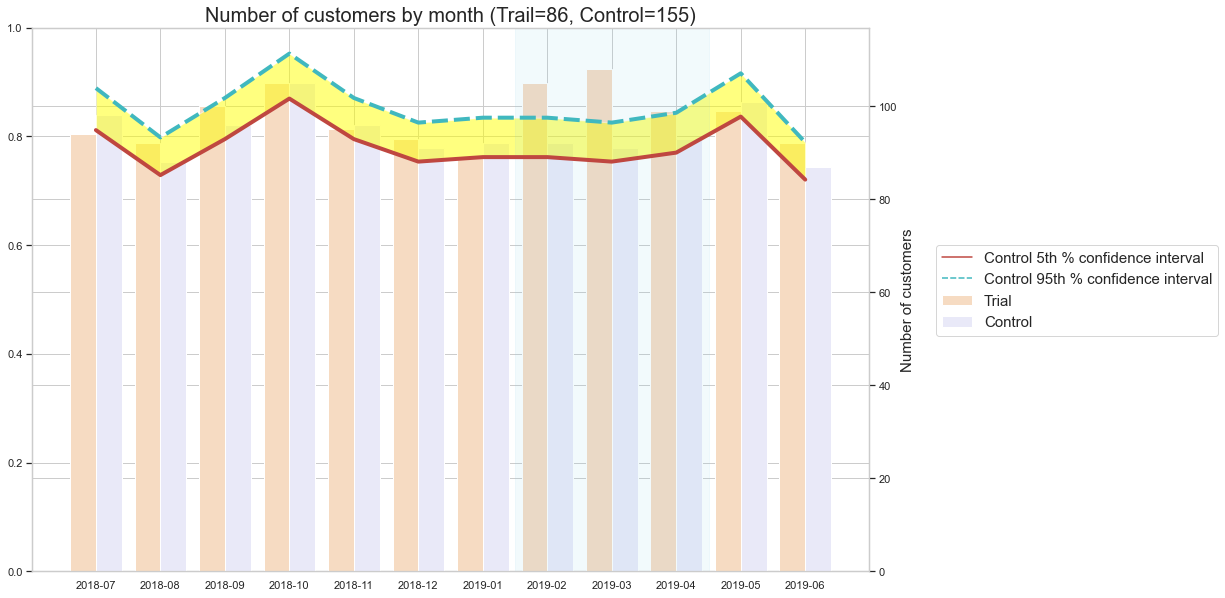

In [80]:
plot_graph(trialAssessmentCustomers_86, "TOT_CUST", "Number of customers", "Number of customers by month (Trail=86, Control=155)")

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

## STORE 88

Now let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [81]:
trial_store = 88

In [82]:
# Calculate correlations
corr_nSales_88 = calculateCorrelation(preTrialMeasures, "TOT_SALE", trial_store)
corr_nCustomers_88 = calculateCorrelation(preTrialMeasures, "TOT_CUST", trial_store)

# Calculate magnitude distances
magnitude_nSales_88 = calculateMagnitudeDistance(preTrialMeasures, "TOT_SALE", trial_store)
magnitude_nCustomers_88 = calculateMagnitudeDistance(preTrialMeasures, "TOT_CUST", trial_store)

- Combine the all the scores calculated using our function to create a composite score to rank on.
- Take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.
- Create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table.


In [83]:
score_nSales_88 = pd.DataFrame({'Store1': corr_nSales_88['Store1'],
                             'Store2': corr_nSales_88['Store2'],
                             'ScoreNSale': 0.5 * corr_nSales_88['corr_measure'] + 0.5 * magnitude_nSales_88['mag_measure']})

In [84]:
score_nCustomers_88 = pd.DataFrame({'Store1': corr_nCustomers_88['Store1'],
                             'Store2': corr_nCustomers_88['Store2'],
                             'ScoreNCust': 0.5*corr_nCustomers_88['corr_measure'] + 0.5*magnitude_nCustomers_88['mag_measure']})


Combine scores across the drivers by first merging our sales scores and customer scores into a single table

In [85]:
score_Control_88 = pd.DataFrame({'Store1': score_nCustomers_88['Store1'],
                             'Store2': score_nCustomers_88['Store2'],
                             'finalControlScore': 0.5*score_nSales_88['ScoreNSale'] + 0.5*score_nCustomers_88['ScoreNCust']})\
                             .sort_values(by='finalControlScore', ascending=False)
score_Control_88

,Store1,Store2,finalControlScore
82,88,88,1.0
224,88,237,0.747479
115,88,123,0.699282
6,88,7,0.665584
169,88,178,0.651635
...,...,...,...
226,88,239,-0.131349
250,88,264,-0.132799
252,88,266,-0.137143
127,88,135,-0.144894


- The store with the highest score is then selected as the control store since it is most similar to the trial store.
- Select control stores based on the highest matching store (closest to 1 but not the store itself, i.e. the second ranked highest store)
- Select the most appropriate control store for trial store by finding the store with the highest final score. as control_store
- Store 88 is the store with the highest score that is selected as the control store.

In [86]:
control_store = 237

In [87]:
# Add Store_type column
measureOverTime_88 = measureOverTime

measureOverTime_88["STORE_TYPE"] = np.where(measureOverTime_88["STORE_NBR"] == trial_store, "Trial",
                                                  np.where(measureOverTime_88["STORE_NBR"] == control_store, "Control", "Other stores"))

# Convert YEARMONTH to DateTime
measureOverTime_88["MONTH"] = pd.to_datetime(measureOverTime_88["YEAR_MONTH"].astype(str).apply(lambda x: f"{x[:4]}-{x[4:]}-01"))

measureOverTime_88

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH
0,1,201807,188.9,47.0,58.0,1.042553,1.183673,3.256897,Other stores,2018-07-01
1,1,201808,168.4,41.0,52.0,1.000000,1.268293,3.238462,Other stores,2018-08-01
2,1,201809,268.1,57.0,71.0,1.035088,1.203390,3.776056,Other stores,2018-09-01
3,1,201810,175.4,39.0,51.0,1.025641,1.275000,3.439216,Other stores,2018-10-01
4,1,201811,184.8,44.0,55.0,1.022727,1.222222,3.360000,Other stores,2018-11-01
...,...,...,...,...,...,...,...,...,...,...
3160,272,201902,385.3,44.0,89.0,1.068182,1.893617,4.329213,Other stores,2019-02-01
3161,272,201903,421.9,48.0,97.0,1.062500,1.901961,4.349485,Other stores,2019-03-01
3162,272,201904,445.1,54.0,105.0,1.037037,1.875000,4.239048,Other stores,2019-04-01
3163,272,201905,314.6,34.0,71.0,1.176471,1.775000,4.430986,Other stores,2019-05-01


### SALES Analysis

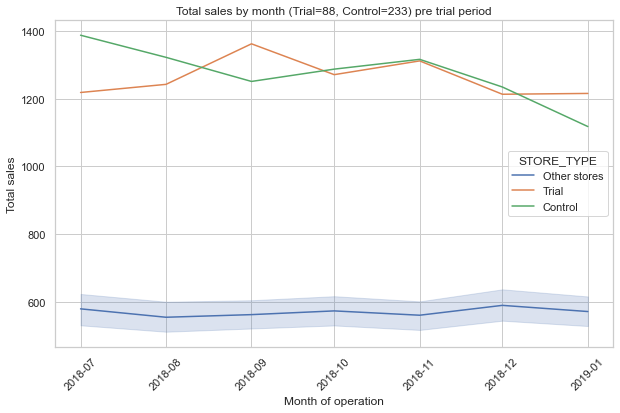

In [88]:
plot_trial_control_stores(measureOverTime_88, trial_store, control_store, "TOT_SALE", "Total sales", "Total sales by month (Trial=88, Control=233) pre trial period")

- The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.
- We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

##### Scale pre-trial control sales to match pre-trial trial store sales

In [89]:
scalingFactorForControlSales_88 = scale_factor(preTrialMeasures ,trial_store, control_store, "TOT_SALE")

##### Apply the scaling factor

In [90]:
scaledControlSales_88 = scaled_matric(measureOverTime_88, control_store, "TOT_SALE", scalingFactorForControlSales_88)
scaledControlSales_88

,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH,CONTROL_SCALE
2743,237,201807,1387.2,125.0,312.0,1.248000,2.000000,4.446154,Control,2018-07-01,1374.394024
2744,237,201808,1321.9,132.0,304.0,1.219697,1.888199,4.348355,Control,2018-08-01,1309.696842
2745,237,201809,1250.8,120.0,285.0,1.191667,1.993007,4.388772,Control,2018-09-01,1239.253204
2746,237,201810,1287.1,118.0,287.0,1.220339,1.993056,4.484669,Control,2018-10-01,1275.218100
2747,237,201811,1316.0,125.0,304.0,1.224000,1.986928,4.328947,Control,2018-11-01,1303.851308
2748,237,201812,1234.4,121.0,283.0,1.173554,1.992958,4.361837,Control,2018-12-01,1223.004601
2749,237,201901,1117.7,111.0,257.0,1.162162,1.992248,4.349027,Control,2019-01-01,1107.381921
2750,237,201902,1313.0,119.0,296.0,1.243697,2.000000,4.435811,Control,2019-02-01,1300.879003
2751,237,201903,1177.6,116.0,268.0,1.155172,2.000000,4.394030,Control,2019-03-01,1166.728952
2752,237,201904,1153.6,116.0,262.0,1.129310,2.000000,4.403053,Control,2019-04-01,1142.950509


#### Calculate the percentage difference between scaled control sales and trial sales

In [91]:
percentageDiffSales_88 = calculate_percentage_difference(measureOverTime_88, scaledControlSales_88, trial_store, control_store, "TOT_SALE")
percentageDiffSales_88

,MONTH,TOT_SALE,CONTROL_SCALE,PERCENT_DIFF
0,2018-07-01,1218.20,1374.394024,0.113646
1,2018-08-01,1242.20,1309.696842,0.051536
2,2018-09-01,1361.80,1239.253204,0.098888
3,2018-10-01,1270.80,1275.218100,0.003465
4,2018-11-01,1311.40,1303.851308,0.005790
5,2018-12-01,1213.00,1223.004601,0.008180
6,2019-01-01,1215.40,1107.381921,0.097544
7,2019-02-01,1339.60,1300.879003,0.029765
8,2019-03-01,1467.00,1166.728952,0.257361
9,2019-04-01,1317.00,1142.950509,0.152281


### Hypothesis Analysis
- **H0** = The trial period is the same as the pre-trial period
- **HA** = The trial period is not the same as the pre-trial period
- As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period

In [92]:
# Assuming you have the 'percentageDiff' column in the merged_data DataFrame
stdDevSales_88 = standard_deviation(percentageDiffSales_88)
stdDevSales_88

0.0490781577818775

#### We will test with a null hypothesis of there being 0 difference between trial and control stores.
- Calculate the t-values for the trial months.
- After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.
#### The test statistic here is (x - u)/standard deviation

In [93]:
percentageDiffSales_88['tValue'] = (percentageDiffSales_88['PERCENT_DIFF'] - 0) / stdDevSales_88
percentageDiffSales_88[(percentageDiffSales_88['MONTH'] >= '2019-02-01') & (percentageDiffSales_88['MONTH'] < '2019-05-01')]

,MONTH,TOT_SALE,CONTROL_SCALE,PERCENT_DIFF,tValue
7,2019-02-01,1339.6,1300.879003,0.029765,0.606487
8,2019-03-01,1467.0,1166.728952,0.257361,5.243910
9,2019-04-01,1317.0,1142.950509,0.152281,3.102824


- The 95th percentile of the t distribution with the appropriate degrees of freedom
- There are 8 months in the pre-trial period, hence degrees of freedom = 8 - 1 = 7

In [94]:
percentile_95 = stats.t.ppf(0.95, df=7)
percentile_95

1.8945786050613047

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.
#### Trial and control store total sales


In [95]:
pastSales_88 = past(measureOverTime_88, trial_store, control_store, "TOT_SALE")
#pastSales_88

#### Control store 95th percentile

In [96]:
pastSales_Controls95_88 = past_control_95(pastSales_88, stdDevSales_88, "TOT_SALE")

#### Control store 5th percentile

In [97]:
pastSales_Controls5_88 = past_control_5(pastSales_88, stdDevSales_88, "TOT_SALE")

In [98]:
trialAssessment_88 = pd.concat([pastSales_88, pastSales_Controls95_88, pastSales_Controls5_88], ignore_index=True)
trialAssessment_88

,MONTH,STORE_TYPE,TOT_SALE
0,2018-07-01,Trial,1218.200000
1,2018-08-01,Trial,1242.200000
2,2018-09-01,Trial,1361.800000
3,2018-10-01,Trial,1270.800000
4,2018-11-01,Trial,1311.400000
5,2018-12-01,Trial,1213.000000
6,2019-01-01,Trial,1215.400000
7,2019-02-01,Trial,1339.600000
8,2019-03-01,Trial,1467.000000
9,2019-04-01,Trial,1317.000000


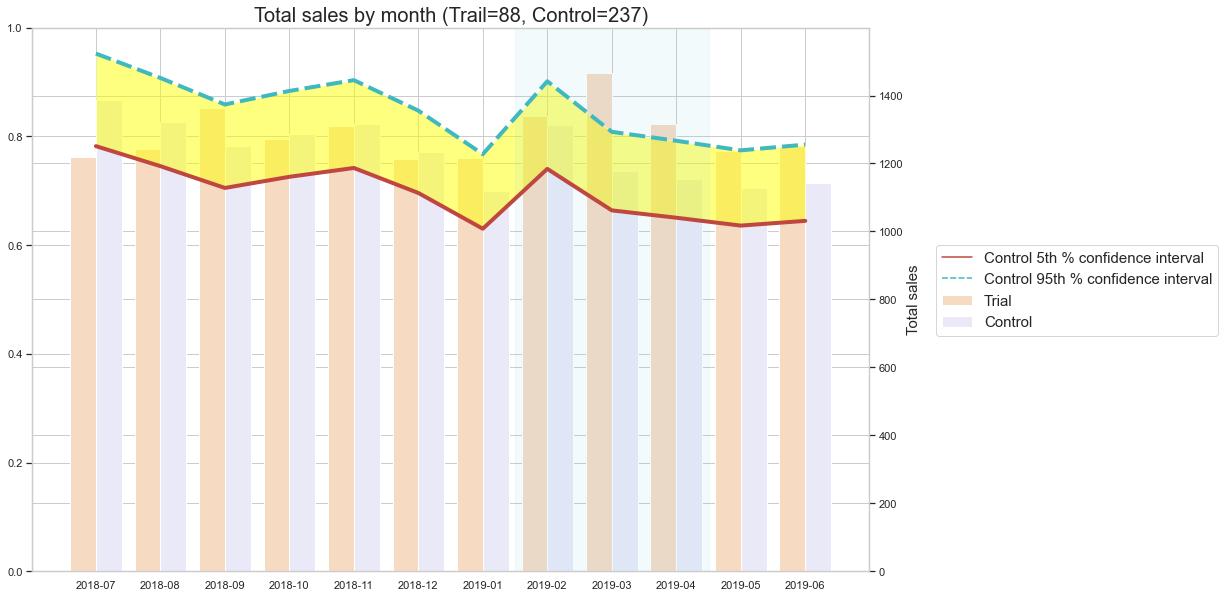

In [99]:
plot_graph(trialAssessment_88, "TOT_SALE", "Total sales", "Total sales by month (Trail=88, Control=237)")

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies **outside** of the 5% to 95% confidence interval of the control store in two of the three trial months.

### Customer Analysis

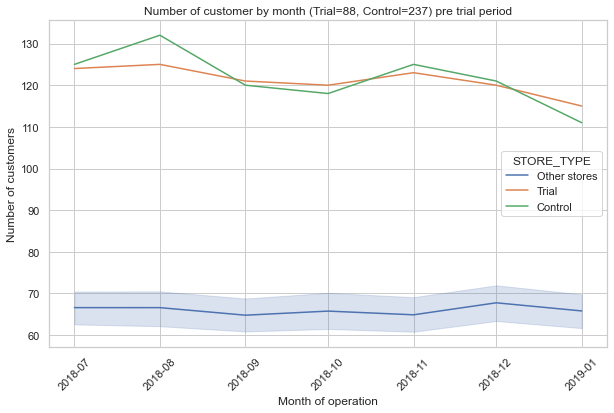

In [100]:
plot_trial_control_stores(measureOverTime_88, trial_store, control_store, "TOT_CUST", "Number of customers", "Number of customer by month (Trial=88, Control=237) pre trial period")

##### Scale pre-trial control sales to match pre-trial trial store sales

In [101]:
scalingFactorForControlCustomers_88 = scale_factor(preTrialMeasures ,trial_store, control_store, "TOT_CUST")

##### Apply the scaling factor

In [102]:
scaledControlCustomers_88 = scaled_matric(measureOverTime_88, control_store, "TOT_CUST", scalingFactorForControlCustomers_88)
scaledControlCustomers_88


,STORE_NBR,YEAR_MONTH,TOT_SALE,TOT_CUST,PROD_QTY,TXN_PER_CUST,CHIPS_PER_TXN,PRICE_PER_UNIT,STORE_TYPE,MONTH,CONTROL_SCALE
2743,237,201807,1387.2,125.0,312.0,1.248000,2.000000,4.446154,Control,2018-07-01,124.413146
2744,237,201808,1321.9,132.0,304.0,1.219697,1.888199,4.348355,Control,2018-08-01,131.380282
2745,237,201809,1250.8,120.0,285.0,1.191667,1.993007,4.388772,Control,2018-09-01,119.436620
2746,237,201810,1287.1,118.0,287.0,1.220339,1.993056,4.484669,Control,2018-10-01,117.446009
2747,237,201811,1316.0,125.0,304.0,1.224000,1.986928,4.328947,Control,2018-11-01,124.413146
2748,237,201812,1234.4,121.0,283.0,1.173554,1.992958,4.361837,Control,2018-12-01,120.431925
2749,237,201901,1117.7,111.0,257.0,1.162162,1.992248,4.349027,Control,2019-01-01,110.478873
2750,237,201902,1313.0,119.0,296.0,1.243697,2.000000,4.435811,Control,2019-02-01,118.441315
2751,237,201903,1177.6,116.0,268.0,1.155172,2.000000,4.394030,Control,2019-03-01,115.455399
2752,237,201904,1153.6,116.0,262.0,1.129310,2.000000,4.403053,Control,2019-04-01,115.455399


#### Calculate the percentage difference between scaled control sales and trial sales

In [103]:
percentageDiffCustomers_88 = calculate_percentage_difference(measureOverTime_88, scaledControlCustomers_88, trial_store, control_store, "TOT_CUST")
percentageDiffCustomers_88

,MONTH,TOT_CUST,CONTROL_SCALE,PERCENT_DIFF
0,2018-07-01,124.0,124.413146,0.003321
1,2018-08-01,125.0,131.380282,0.048563
2,2018-09-01,121.0,119.436620,0.013090
3,2018-10-01,120.0,117.446009,0.021746
4,2018-11-01,123.0,124.413146,0.011358
5,2018-12-01,120.0,120.431925,0.003586
6,2019-01-01,115.0,110.478873,0.040923
7,2019-02-01,122.0,118.441315,0.030046
8,2019-03-01,133.0,115.455399,0.151960
9,2019-04-01,119.0,115.455399,0.030701


### Hypothesis Analysis
- **H0** = The trial period is the same as the pre-trial period
- **HA** = The trial period is not the same as the pre-trial period
- As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period


In [104]:
stdDevCustomers_88 = standard_deviation(percentageDiffCustomers_88)
stdDevCustomers_88

0.017915383598410627

#### We will test with a null hypothesis of there being 0 difference between trial and control stores.
- Calculate the t-values for the trial months.
- After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.
#### The test statistic here is (x - u)/standard deviation


In [105]:
percentageDiffCustomers_88['tValue'] = (percentageDiffCustomers_88['PERCENT_DIFF'] - 0) / stdDevCustomers_88
percentageDiffCustomers_88[(percentageDiffCustomers_88['MONTH'] >= '2019-02-01') & (percentageDiffCustomers_88['MONTH'] < '2019-05-01')]

,MONTH,TOT_CUST,CONTROL_SCALE,PERCENT_DIFF,tValue
7,2019-02-01,122.0,118.441315,0.030046,1.677105
8,2019-03-01,133.0,115.455399,0.151960,8.482095
9,2019-04-01,119.0,115.455399,0.030701,1.713669


- The 95th percentile of the t distribution with the appropriate degrees of freedom
- There are 8 months in the pre-trial period, hence degrees of freedom = 8 - 1 = 7

In [106]:
percentile_95 = stats.t.ppf(0.95, df=7)
percentile_95

1.8945786050613047

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.
#### Trial and control store total sales

In [107]:
pastCustomers_88 = past(measureOverTime_88, trial_store, control_store, "TOT_CUST")
#pastSales_88

#### Control store 95th percentile

In [108]:
pastCustomers_Controls95_88 = past_control_95(pastCustomers_88, stdDevCustomers_77, "TOT_CUST")

#### Control store 5th percentile

In [109]:
pastCustomers_Controls5_88 = past_control_5(pastCustomers_88, stdDevCustomers_77, "TOT_CUST")

In [110]:
trialAssessmentCustomers_88 = pd.concat([pastCustomers_88, pastCustomers_Controls95_88, pastCustomers_Controls5_88], ignore_index=True)
trialAssessmentCustomers_88

,MONTH,STORE_TYPE,TOT_CUST
0,2018-07-01,Trial,124.000000
1,2018-08-01,Trial,125.000000
2,2018-09-01,Trial,121.000000
3,2018-10-01,Trial,120.000000
4,2018-11-01,Trial,123.000000
5,2018-12-01,Trial,120.000000
6,2019-01-01,Trial,115.000000
7,2019-02-01,Trial,122.000000
8,2019-03-01,Trial,133.000000
9,2019-04-01,Trial,119.000000


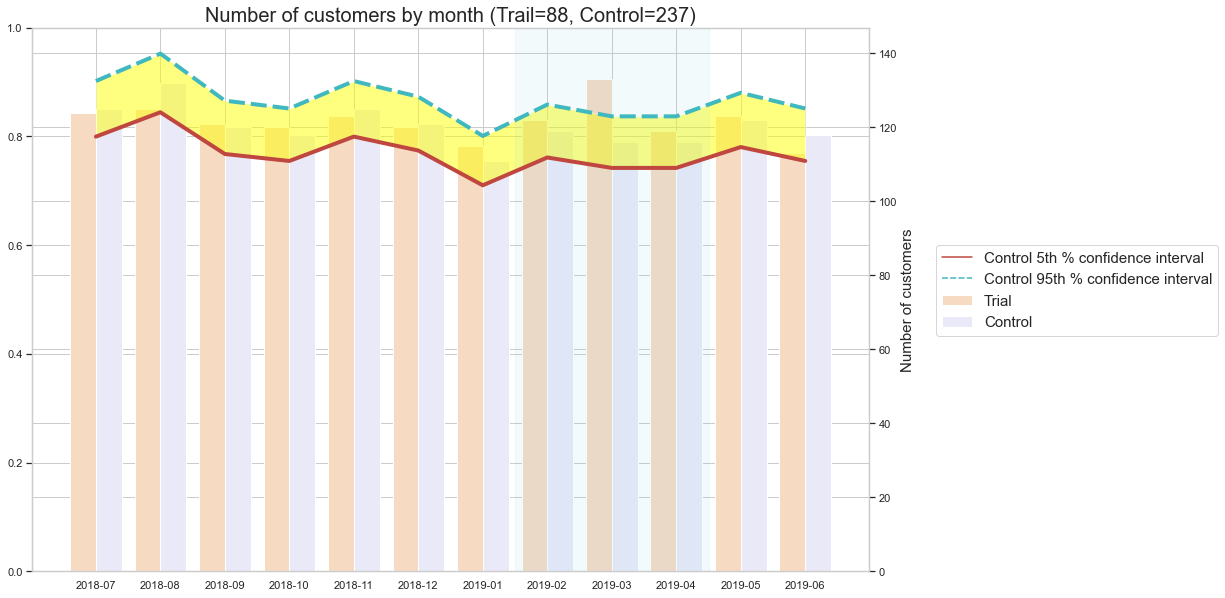

In [111]:
plot_graph(trialAssessmentCustomers_88, "TOT_CUST", "Number of customers", "Number of customers by month (Trail=88, Control=237)")

Total number of customers in the trial period for the trial store 88 is significantly
higher than the control store for two out of three months, which indicates a
positive trial effect.

## Conclusion

We've found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.

The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that we have finished our analysis, we can prepare our presentation to the Category Manager.